# EDA, Simple Linear Regression

In this assignment, we will use a simplified data and create a simple linear regression model. The dataset can be downloaded from https://www.kaggle.com/harlfoxem/housesalesprediction/download.    
This dataset contains house sale prices for Kings County, which includes Seattle. It includes homes sold between May 2014 and May 2015. There are several versions of the data. Some additional information about the columns is available here: https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/, some of which are copied below.

|Variable |	Description|
|:---------|:-------------|
|id 	|Identification|
|date |	Date sold|
|price |	Sale price|
|bedrooms |	Number of bedrooms|
|bathrooms |	Number of bathrooms|
|sqft_liv |	Size of living area in square feet|
|sqft_lot| 	Size of the lot in square feet|
|floors |	Number of floors|
|waterfront |	‘1’ if the property has a waterfront, ‘0’ if not.|
|view |	An index from 0 to 4 of how good the view of the property was|
|condition |	Condition of the house, ranked from 1 to 5|
|grade |	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value.|
|sqft_above |	Square feet above ground|
|sqft_basmt |	Square feet below ground|
|yr_built 	|Year built|
|yr_renov |	Year renovated. ‘0’ if never renovated|
|zipcode |	5 digit zip code|
|lat 	|Latitude|
|long 	|Longitude|
|squft_liv15 |	Average size of interior housing living space for the closest 15 houses, in square feet|
|squft_lot15 |	Average size of land lost for the closest 15 houses, in square feet|

In [3]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

## 1. Munging data
In this part, let's load and inspect data. We will also learn how to transform columns when needed.

In [4]:
df = pd.read_csv('data/house_data_washington.csv')

### 1a) Date string to numbers
Now, let's overview the dataframe. Using `.head()` on the dataframe, we can see the first 5 rows of the data.

The column 'date' is the date sold (with some black timestamp as well), and the data is string type (Note that sometimes data tables may have date/time columns as datetime object types. In this example data, it has a string type). We will extract year and month information from the string. 
In the data frame `df`, let's create new features 'sales_year' and 'sales_month' using 'date' column. 

In this case, when we inspect the 'date' column, it is a string object, so we can slice the year and month from the string. Also, we'd like to convert the extracted year and month strings to integers.

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
print(df.date)
print(type(df.date.iloc[0]))

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object
<class 'str'>


In [7]:
# extract year and month info from the string
# create new features 'sales_year' and 'sales_month' in df

df['sales_year'] = df.date.apply(lambda x: int(x[:4]))
df['sales_month'] = df.date.apply(lambda x: int(x[4:6]))

In [8]:
df.groupby('sales_month')

Now, let's count how many sales occurred in each month and each year. We can use `.groupby()` function to group by 'sales_month' and 'sales_year' as shown below. 

In [9]:
print(df.groupby('sales_month')['id'].count())
print(df.groupby('sales_year')['id'].count())

sales_month
1      978
2     1250
3     1875
4     2231
5     2414
6     2180
7     2211
8     1940
9     1774
10    1878
11    1411
12    1471
Name: id, dtype: int64
sales_year
2014    14633
2015     6980
Name: id, dtype: int64


**Question 1a-1.** Based on the output from above cell, which month has the most number of sales?

In [10]:
print(df.groupby('sales_month')['id'].count().nlargest(1))
most_sales_month = 5

sales_month
5    2414
Name: id, dtype: int64


In [11]:
# tests solutions for most_sales 

**Question 1a-2.** Which months has the least number of sales?

In [12]:
print(df.groupby('sales_month')['id'].count().nsmallest(1))

least_sales_month = 1

sales_month
1    978
Name: id, dtype: int64


In [13]:
# tests solutions for least_sales

Now, let's have a look at what data type each columns has. We can use `.info()` method on the dataframe object to see the data type. You can see `int64`, `float64` and `object` in our example. `object` can be string type or something else (such as list or other types of objects). 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### 1b) Drop features
Let's drop features that are unnecessary. `id` is not a meaningful feature. `date` string has been coded to `sales_month` and `sales_year`, so we can remove `date`. `zipcode` can be also removed as it's hard to include in a linear regression model and the location info is included in the `lat` and `long`.


In [15]:
df = df.drop(columns=['id', 'date', 'zipcode'])

In [16]:
# tests that you droppd the features id, date, and zipcode from df

## 2. More inspection; Correlation and pair plot
### 2a) Get correlation matrix on the data frame.
Which feature may be the best predictor of price based on the correlation?

In [17]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,sales_year,sales_month
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,0.307003,0.021626,0.585379,0.082447,0.003576,-0.010081
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.008931,0.129473,0.391638,0.029244,-0.009838,-0.001533
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042,0.568634,0.087175,-0.026596,0.007392
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223,0.756420,0.183286,-0.029038,0.011810
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.085683,0.229521,0.144608,0.718557,0.005468,-0.002369
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,0.049614,0.125419,0.279885,-0.011269,-0.022315,0.014005
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,-0.014274,-0.041910,0.086463,0.030703,-0.004165,0.008132
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.006157,-0.078400,0.280439,0.072575,0.001364,-0.005638
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,-0.014941,-0.106500,-0.092824,-0.003406,-0.045589,0.021978
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372,0.713202,0.119248,-0.030387,0.008376


In [18]:
best_guess_predictor = 'sqft_living'

In [19]:
# tests the solution for best_guess_predictor

### 2b) Display the correlation matrix as heat map
[`seaborn.heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) can visualize a matrix as a heatmap. Visualize the correlation matrix using seaborn.heatmap().

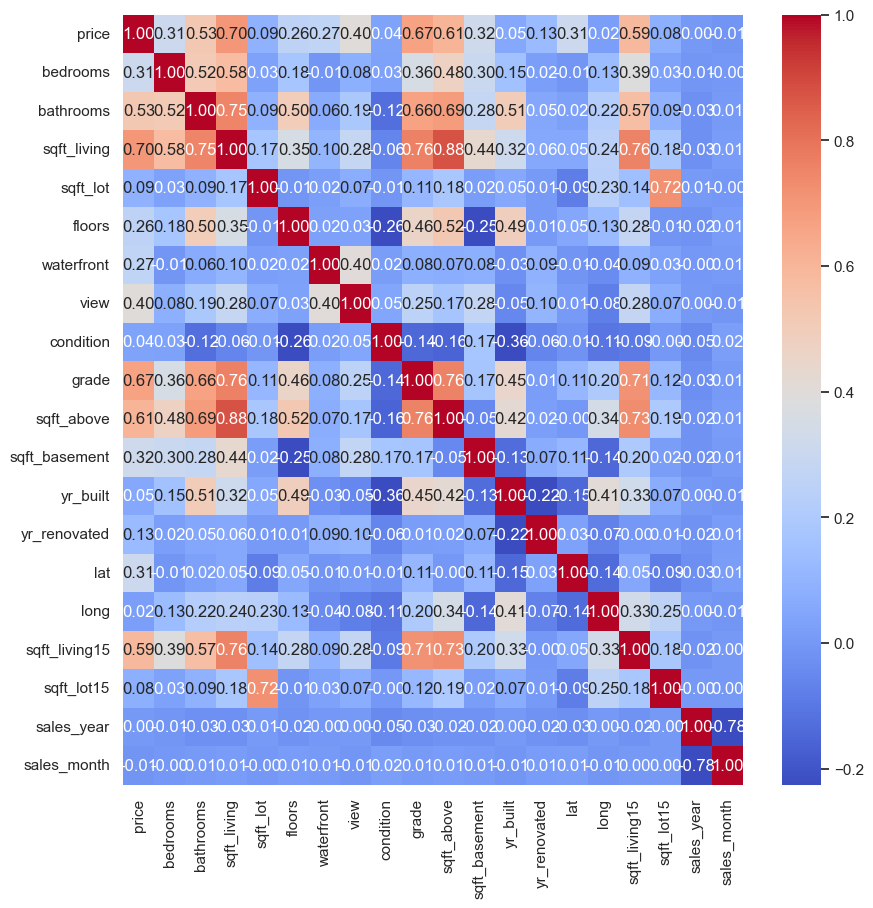

In [20]:
matrix_corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(matrix_corr, annot=True, fmt='.2f', cmap='coolwarm', robust=True)
plt.show()

### 2c) Pair plot
Pair plot is a fast way to inspect relationships between features.

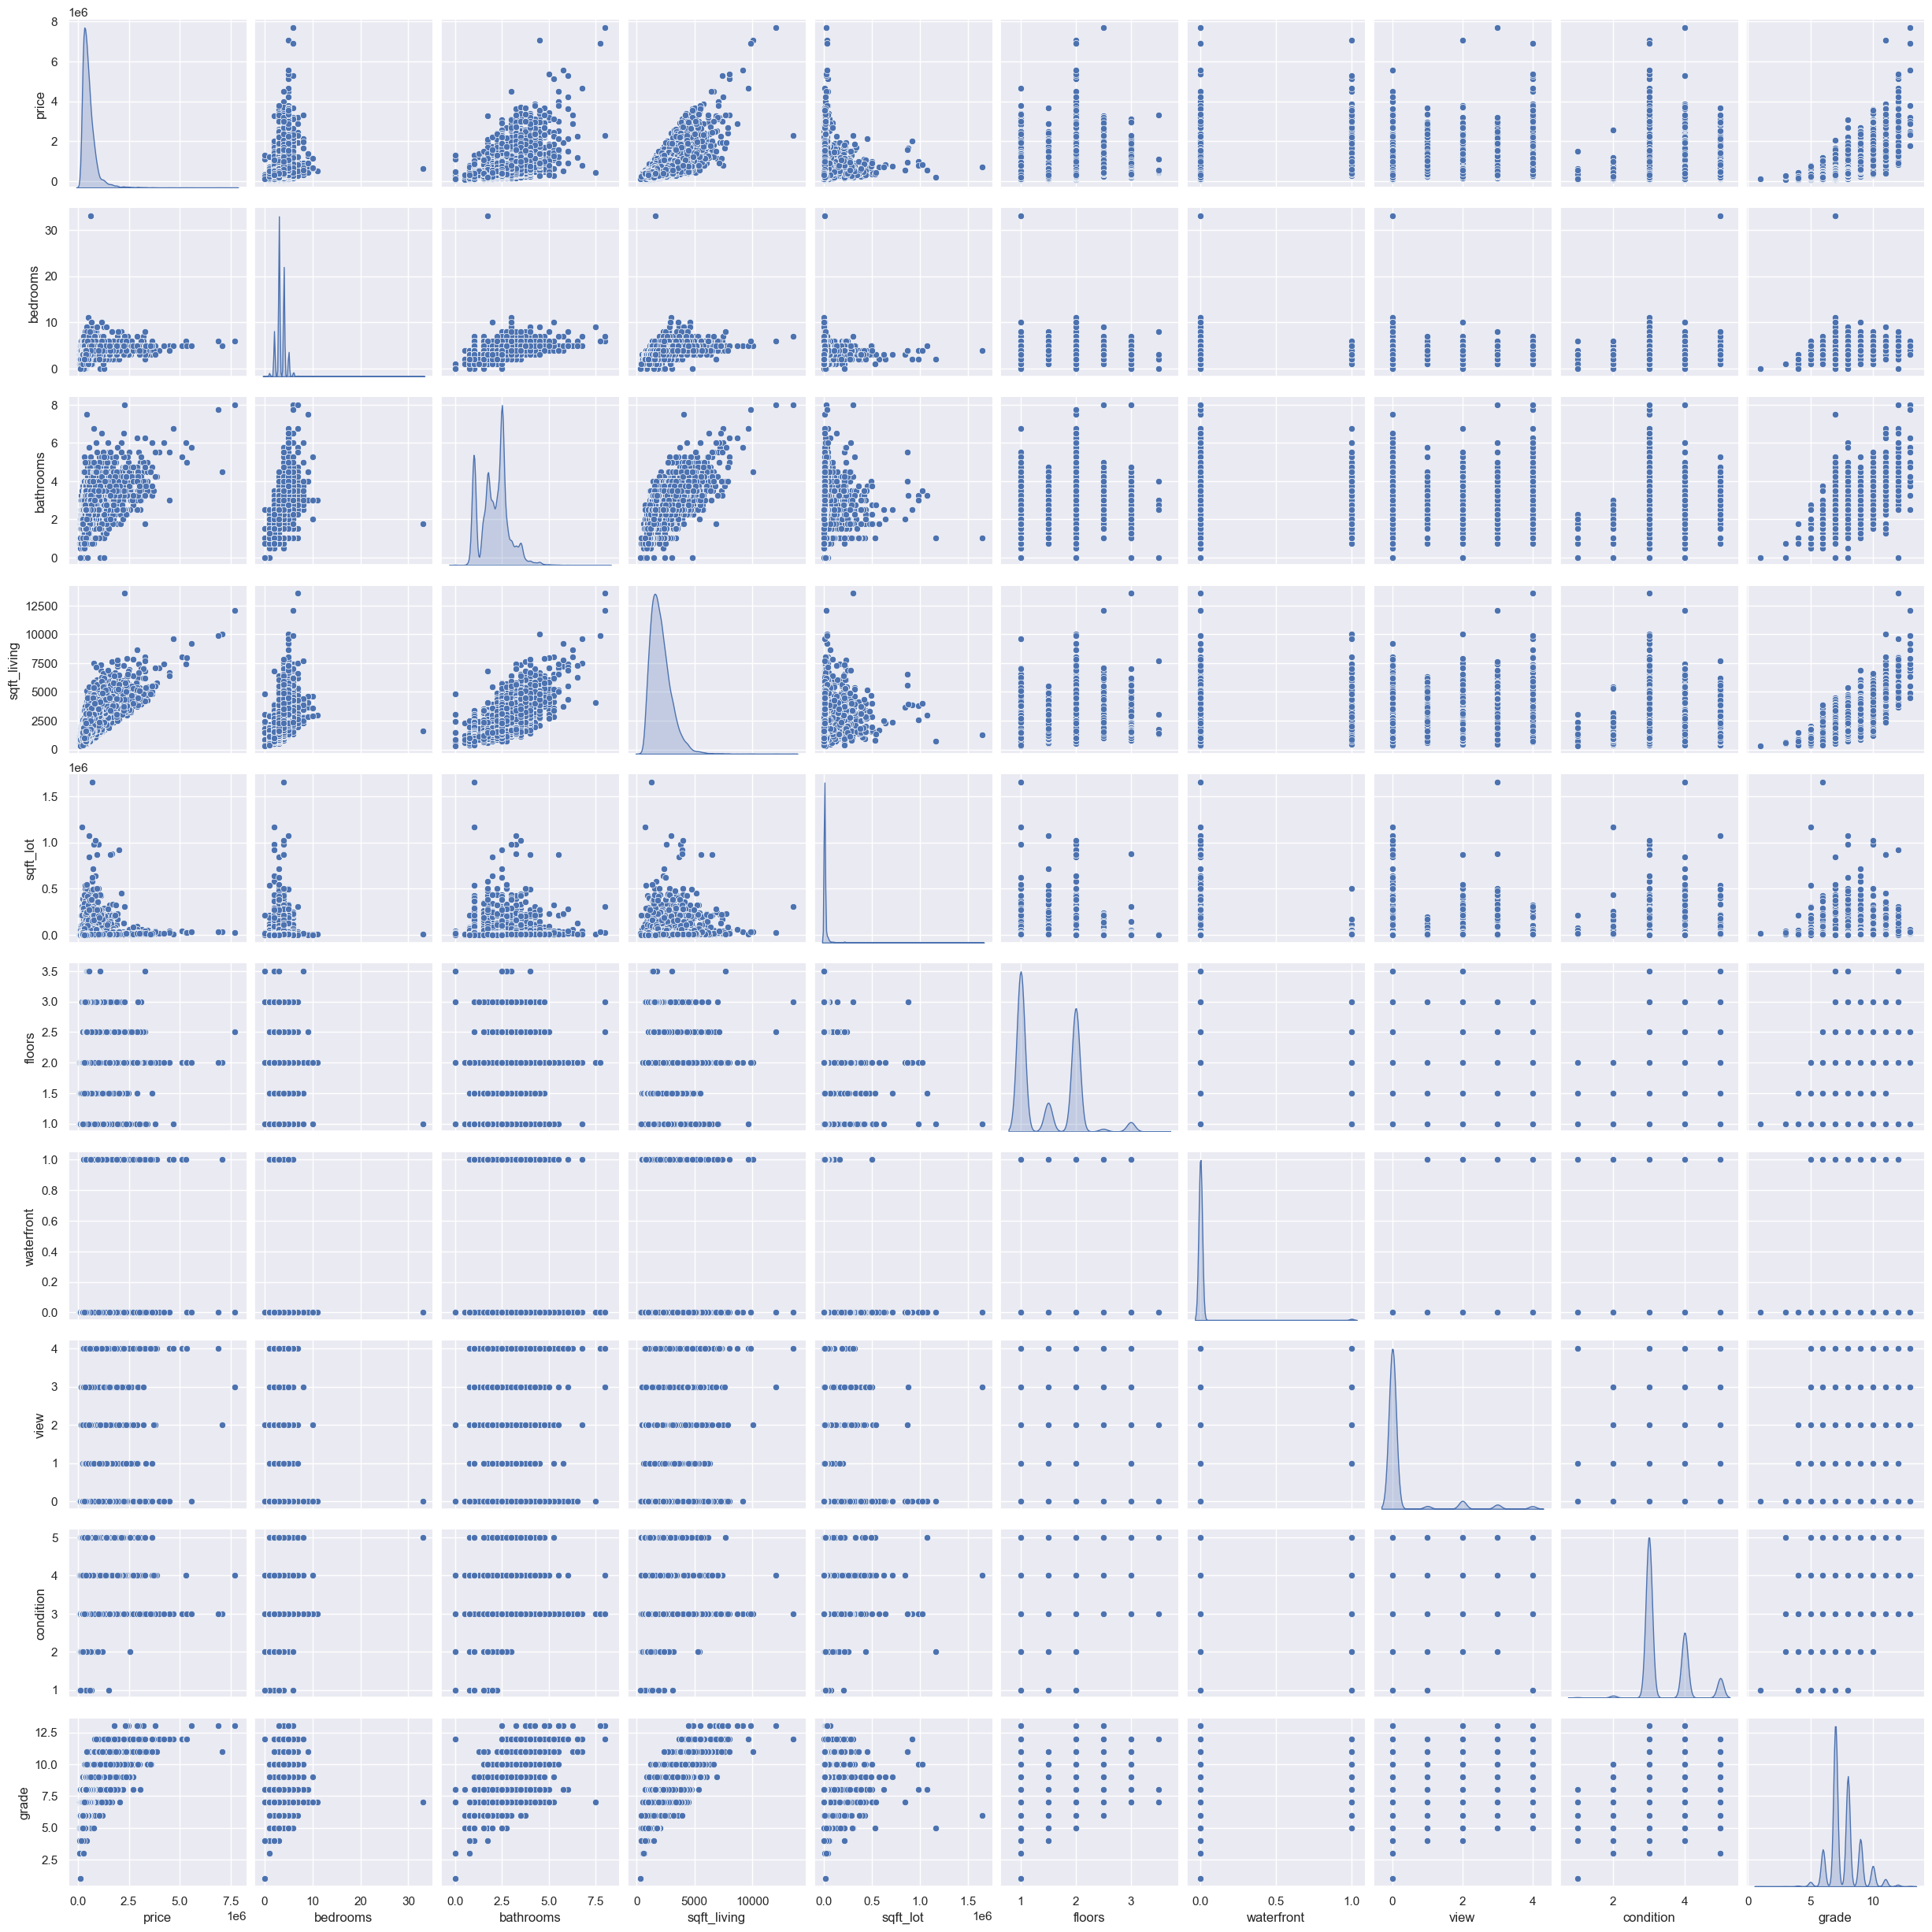

In [21]:
columns_to_plot = df.columns[:10]
df_subset = df[columns_to_plot]

sns.pairplot(df_subset, diag_kind='kde')
plt.show()

## 3. Simple linear regression

### 3a) Data preparation
We will split the data to train and test datasets such that the test dataset is 20% of original data.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, train_size=0.8, random_state=42)

print(f"Size of X_train: {len(X_train)}")
print(f"Size of X_test: {len(X_test)}")


Size of X_train: 17290
Size of X_test: 4323


In [23]:
# Testing cell for self-check
assert(len(X_train) == 17290), "Check 3a, did you split properly so X_Train is 80% of the observations?"
assert(type(X_train)==type(pd.DataFrame())), "Check 3a, what type of object should X_train be?"

In [24]:
# Testing cell 

In [25]:
# Testing cell 


### 3b) Train a simple linear regression model

In [26]:
import statsmodels.formula.api as smf

formula = 'price ~ sqft_living'
model = smf.ols(formula=formula, data=X_train).fit()

print(model.summary())

adj_R2 = model.rsquared_adj
print(f'Adjusted R-squared: {adj_R2}')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.677e+04
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:59:15   Log-Likelihood:            -2.3995e+05
No. Observations:               17290   AIC:                         4.799e+05
Df Residuals:                   17288   BIC:                         4.799e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -4.2e+04   4886.778     -8.594      

In [27]:
# self test
assert len(model.params.index) == 2, 'Check 3b, Number of model parameters (including intercept) does not match. Did you make a univariate model?'

In [28]:
# hidden test for 3b

In [29]:
# hidden test for 3b
                                                                          

### 3c) Best predictor

In [30]:
predictors = X_train.columns.drop('price')
adjusted_r2_scores = {}

for predictor in predictors:
    formula = f'price ~ {predictor}'
    model = smf.ols(formula=formula, data=X_train).fit()
    adjusted_r2_scores[predictor] = model.rsquared_adj

sorted_predictors = sorted(adjusted_r2_scores, key=adjusted_r2_scores.get, reverse=True)

print("Ranked list of predictors based on Adjusted R-squared:")
for predictor in sorted_predictors:
    print(f"{predictor}: {adjusted_r2_scores[predictor]:.4f}")

top_three = sorted_predictors[:3]
print("\nTop three predictors:")
print(top_three)

top_three = ['sqft_living', 'grade', 'sqft_above']

Ranked list of predictors based on Adjusted R-squared:
sqft_living: 0.4924
grade: 0.4423
sqft_above: 0.3639
sqft_living15: 0.3395
bathrooms: 0.2773
view: 0.1537
sqft_basement: 0.1032
lat: 0.0965
bedrooms: 0.0950
floors: 0.0642
waterfront: 0.0639
yr_renovated: 0.0163
sqft_lot: 0.0082
sqft_lot15: 0.0062
yr_built: 0.0024
condition: 0.0013
long: 0.0005
sales_month: 0.0001
sales_year: 0.0001

Top three predictors:
['sqft_living', 'grade', 'sqft_above']


In [31]:
# self test cell
assert(type(top_three) == list), "Check 3c, the top_three needs to be a list."
assert(len(top_three) == 3), "Check 3c, the top_three list needs to have three element."

In [32]:
# test cell

In [33]:
# test cell

In [34]:
# test cell

In [35]:
# test cell

In [36]:
# test cell

In [37]:
# test cell